This notebook contains the following two steps for the task of Grammar Error Correction

3. Training Basic Model and debugging.

4. Tuning Basic Model.

## 3. Training the basic model and debugging
## 4. Tuning the basic model 

For the baseline model, i decided to train an Encoder Decoder model with attention

In [1]:
import re
import datetime
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import keras
import tensorflow as tf
from sklearn.metrics import fbeta_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from tensorflow.keras.layers import Embedding,LSTM, TimeDistributed, Dense, Bidirectional
from tensorflow.keras.initializers import HeNormal, GlorotNormal, GlorotUniform
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocess before tokenization :

In [3]:
data = pd.read_csv('drive/MyDrive/GEC/final_preprocessed_15.csv')

In [4]:
pd.options.display.max_colwidth = 500
data[:50]

,error,correct
0,And he took in my favorite subject like soccer .,And he took in my favorite subjects like soccer .
1,"Actually , who let me know about Lang - was him .","Actually , he was the one who let me know about Lang - . ."
2,His Kanji is ability is much better than me .,His Kanji ability is much better than mine .
3,I heard a sentence last night when I watched TV .,I heard a sentence last night when I was watching TV .
4,"When you go uphill , you hvae to bend your back .","When you go uphill , you have to bend your back ."
5,"When you are go smoothly , you have to be more modest .","When everything is going smoothly , you have to be more modest ."
6,The making souvenir is a hard and interesting work .,Making souvenirs is a hard but interesting work .
7,"You know , you can take them at slot machine .","You know , you can ? them at a slot machine ."
8,The third memory is the house we lived .,The third memory is the house where we lived .
9,I liked the winter Finland .,I liked Finland in the Winter .


In [5]:
data[50:100]

,error,correct
50,I am listening to music with the commuter train .,I am listening to music on the commuter train .
51,"Today , I listen the music , it looks like in the cafe .","Today , I listen the music , it feels like I am in a cafe ."
52,Spring is very exciting season .,Spring is a very exciting season .
53,"Japanese school , work starts spring .","In Japan , the new school and work year starts in spring ."
54,I hope to get any quarifications in english .,I hope to become qualified in English .
55,I hope to get my new promotions .,I hope to get a new promotion .
56,Everyday starts new thinngs to try .,"Everyday , there are new things to try ."
57,". . . No , extremely sometimes .",". . . No , very frequently ."
58,"Since today , I am going to try write a diary ! !","Starting today , I am going to try write a diary everyday ! !"
59,Today is nothing specal to write ! !,Today has nothing specal to write ! !


Since preprocessing of data is already done before, all we do is add the tokens required to feed the data into our Encoder Decoder model with attention.
We implement the teacher forcing approach such that the the data looks like this: 
1. Encoder input: 
```
<start> Hello how are youz ? <end>
```
2. Decoder input: 
```
<start> Hello how are you ?
```
3. Decoder output: 
```
Hello how are you? <end>
```

This allows the decoder to always stay one step ahead during learning. 

In [5]:
def preprocess(t, add_start_token, add_end_token):

  if add_start_token == True and add_end_token == False:
    t = '<start>'+' '+t
  if add_start_token == False and add_end_token == True:
    t = t+' '+'<end>'
  if add_start_token == True and add_end_token == True:
    t = '<start>'+' '+t+' '+'<end>'

  t = re.sub(' +', ' ', t)
  return t

In [6]:
encoder_input = [preprocess(line, add_start_token= True, add_end_token=True) for line in data['error']]
decoder_input = [preprocess(line, add_start_token= True, add_end_token=False) for line in data['correct']]
decoder_output = [preprocess(line, add_start_token= False, add_end_token=True) for line in data['correct']]

In [7]:
print(encoder_input[0])
print(decoder_input[0])
print(decoder_output[0])

<start> And he took in my favorite subject like soccer . <end>
<start> And he took in my favorite subjects like soccer .
And he took in my favorite subjects like soccer . <end>


Tokenization :

In [8]:
#ENCODER INPUT

tokenizer = Tokenizer(filters='', split=" ")
tokenizer.fit_on_texts(encoder_input)
word_index = tokenizer.word_index #vocabulary

max_length = max([ len(row.split(" ")) for row in encoder_input ])
INPUT_ENCODER_LENGTH = max_length

enc_input_encoded = tokenizer.texts_to_sequences(encoder_input)
enc_input_padded= pad_sequences(enc_input_encoded, maxlen=INPUT_ENCODER_LENGTH, padding="post")

print(enc_input_padded.shape)

(288041, 17)


In [10]:
print(encoder_input[0])
print(enc_input_padded[0])

<start> And he took in my favorite subject like soccer . <end>
[  1  11  46 177  13  10 280 901  39 615   3   2   0   0   0   0   0]


In [11]:
#DECODER INPUT
decoder_data = decoder_input.copy()
decoder_data.extend(decoder_output)

out_tokenizer = Tokenizer(filters='', split=" ")
out_tokenizer.fit_on_texts(decoder_data)
word_index = out_tokenizer.word_index #vocabulary

max_length = max([ len(row.split(" ")) for row in decoder_input ])
INPUT_DECODER_LENGTH = max_length

In [13]:
dec_input_encoded = out_tokenizer.texts_to_sequences(decoder_input)
dec_input_padded= pad_sequences(dec_input_encoded, maxlen=INPUT_DECODER_LENGTH, padding="post", truncating = "post")

print(dec_input_padded.shape)

(288041, 29)


In [14]:
print(decoder_input[0])
print(dec_input_padded[0])

<start> And he took in my favorite subjects like soccer .
[   3   12   46  178   13   10  266 1499   41  608    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [15]:
dec_output_encoded = out_tokenizer.texts_to_sequences(decoder_output)
dec_output_padded= pad_sequences(dec_output_encoded, maxlen=INPUT_DECODER_LENGTH, padding="post", truncating = "post")

print(dec_output_padded.shape)

(288041, 29)


In [16]:
print(decoder_output[1])
print(dec_output_padded[1])

Actually , he was the one who let me know about Lang - . . <end>
[269   6  46  17   5  60 106 316  26  74  37 169  44   1   1   4   0   0
   0   0   0   0   0   0   0   0   0   0   0]


#### ATTENTION MODEL 

- **Model Architecture** consists of an encoder, attention and decoder blocks subclassed from tf.keras.layers.layer class and the final encoder decoder implementation, which is subclassed from tf.keras.Model class
- **Input to model** is a tuple of encoder input and decoder input of size (batch_size, encoder_input_size) and (batch_size, decoder_input_size) and target output for decoder of size (batch_size, decoder_input_size)
- **Output of the model** is of shape (batch_size, decoder_input_size, output_vocab_size) or a dense tensor
- **Loss** used is sparse categorical cross entropy which takes input y_true as a sparse tensor, and y_pred as a dense tensor
- **Metric** used is F beta score with beta = 0.5 which takes sparse y_true and y_pred, so we convert y_pred into a sparse tensor
- **Attention scoring function** used is the dot scoring function

Attention mechanism:
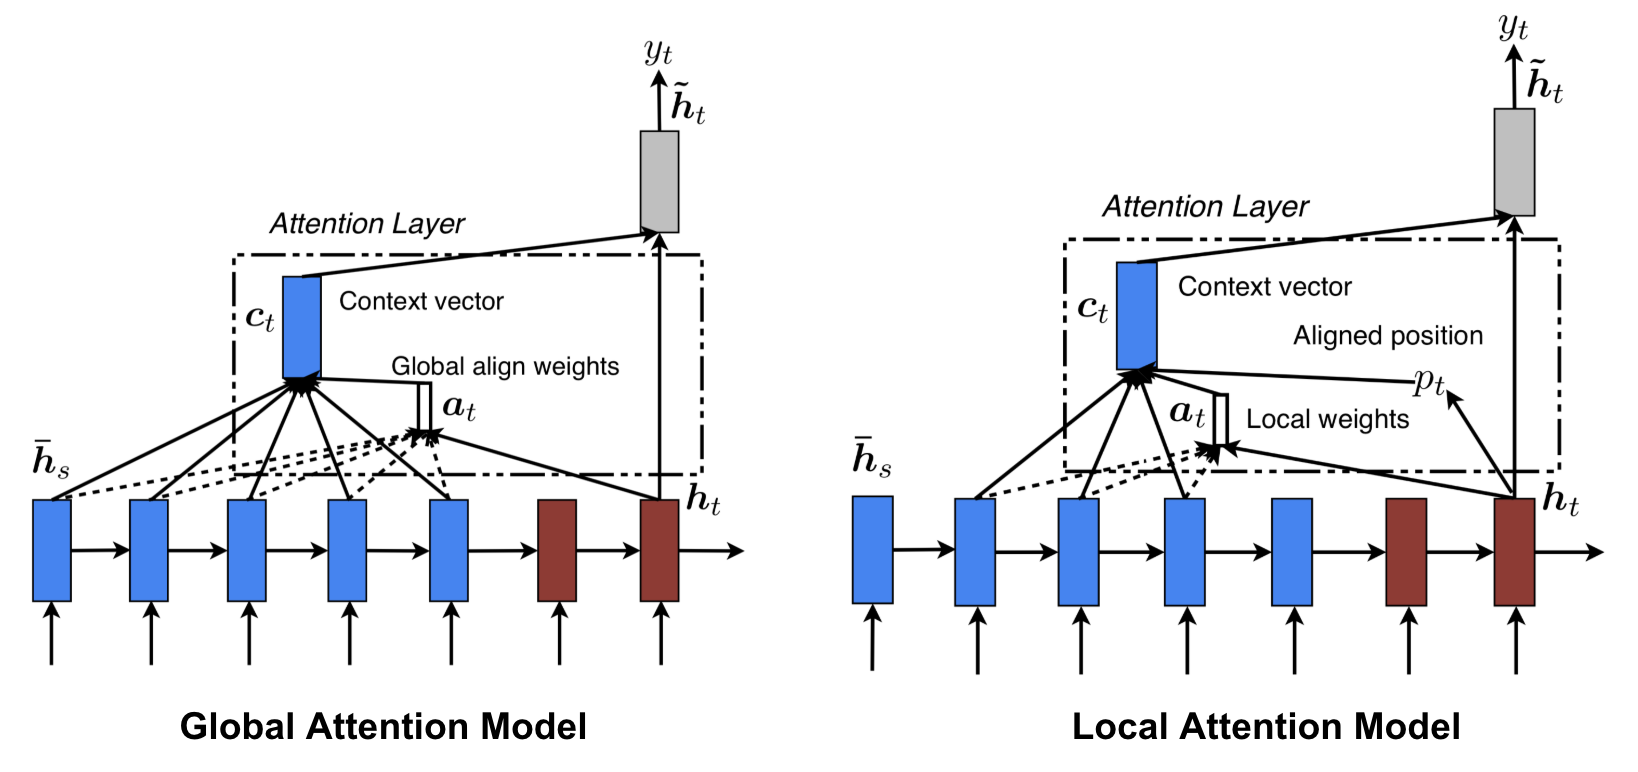

Reference: https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html



The blue blocks on the left bottom denoted by hs bar represents the **encoder output** for all the timesteps. Since there are five blocks shown, we can imagine that the encoder input had five words, which were fed to the encoder block at every timesteps, giving us the output of the encoder at every timestep.

The maroon blocks on the right bottom denoted by ht represents the **decoder hidden state** at every timestep, so for simplicity let's assume the last block is decoding the second word of the input sentence.

As shown on the left image, while decoding, for each step, a **context vector**, ct is created from the encoder output. If **global attention** is used, all the encoder ouputs (i.e. at all timesteps) are used to create this vector. This vector is actually just the sum of the multiplication of each of the output with an **attention weight**. at denotes the vector containing all the attention weight for each timestep. 

To get this attention weight, we use scoring functions and apply it on the encoder output and the decoder hidden states. For e.g., if we are using the dot product scoring function we simply take the dot product of the encoder states and the decoder hidden state to get the attention weight. This weight tells us how much importance or context does each of the encoder state give us for the current decoder state.

For **local attention** as shown on the right, we only use the encoder states in the vicinity of the timestep the decoder is at.

Finally, we concatenate the current decoder hidden state ht with the context vector ct and feed it to the decoder to get the next decoder hidden state ht~.


Load FastText embeddings

In [17]:
in_embedding_matrix = np.load('drive/MyDrive/GEC/in_embedding.npy')
out_embedding_matrix = np.load('drive/MyDrive/GEC/out_embedding.npy')
print(in_embedding_matrix.shape, out_embedding_matrix.shape)

(52383, 300) (41061, 300)


In [18]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_units = lstm_size
        self.input_length = input_length

    def build(self, input_sequence):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length, 
                                   weights = [in_embedding_matrix], mask_zero=True, 
                                   trainable = False, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states):

        input_embedding = self.embedding(input_sequence)   #(batch_size, length of input array, embedding_size)

        self.lstm_output, self.state_h, self.state_c = self.lstm(input_embedding, initial_state= states)  
        
        return self.lstm_output, self.state_h, self.state_c

    
    def initialize_states(self,batch_size):

      lstm_state_h = tf.zeros((batch_size, self.lstm_units), dtype=tf.dtypes.float32, name="Encoder_LSTM_hidden_state")
      lstm_state_c = tf.zeros((batch_size, self.lstm_units), dtype=tf.dtypes.float32, name="Encoder_LSTM_cell_state")

      return lstm_state_h, lstm_state_c      


In [19]:
def dot_func(encoder_output, decoder_hidden_state):
  decoder_hidden_state = tf.reshape(decoder_hidden_state, [decoder_hidden_state.shape[0],1,decoder_hidden_state.shape[1]])
  dot_product = tf.matmul(encoder_output, decoder_hidden_state, transpose_b = True) #(16,10,32) and (16,1,32).T => (16,10,1)
  return dot_product

In [20]:
class Attention(tf.keras.layers.Layer):

  def __init__(self,scoring_function, att_units):
    super().__init__()
    
    self.scoring_function = scoring_function
    self.att_units = att_units
    self.timesteps = 0

  def build(self, data_shape):
      self.encoder_units = data_shape[1]  #Only the TensorShape object for decoder_hidden_state passed
  
  def call(self,decoder_hidden_state,encoder_output):

    if self.scoring_function == 'dot':
        alpha_ = tf.nn.softmax(dot_func(encoder_output, decoder_hidden_state), axis = 1)  #(batch_size, timesteps, 1), Take softmax along timestep axis
        c_t = sum([alpha_[:,i,]*encoder_output[:,i,:] for i in range(alpha_.shape[1])])
        c_t = tf.convert_to_tensor(c_t, dtype= tf.float32)
        return c_t, alpha_
    
    

In [21]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super().__init__()

      self.dec_units = dec_units
      self.att_units = att_units
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.score_fun = score_fun
      self.dense = Dense(self.tar_vocab_size)

  def build(self,input):
      self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, 
                                   weights = [out_embedding_matrix], mask_zero=True, 
                                   trainable = False, name="embedding_layer_decoder") 
      self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True, name="One_step_decoder_LSTM")


  def call(self,input_to_decoder, encoder_output, state_h,state_c):

    input_embedding = self.embedding(input_to_decoder)
    
    if self.score_fun == 'dot':
      attention=Attention('dot',self.att_units)
      context_vector,attention_weights=attention(state_h,encoder_output)

    out = tf.concat([input_embedding,tf.expand_dims(context_vector, axis = 1)], axis =2)  #(batch_size, 1, embedding_dim+att_units)

    self.lstm_output, self.state_h, self.state_c = self.lstm(out, initial_state=[state_h, state_c])
    result_out = self.dense(self.lstm_output)

    return  tf.squeeze(result_out) , self.state_h,self.state_c, attention_weights, context_vector


In [22]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super().__init__()
      self.dec_units = dec_units
      self.att_units = att_units
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.score_fun = score_fun
      self.one_step_decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units ,self.score_fun ,self.att_units)

    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        out_array = tf.TensorArray(tf.float32, size = input_to_decoder.shape[1], name = 'out_array')

        for timestep in range(input_to_decoder.shape[1]): 
          output,decoder_hidden_state,decoder_cell_state,attention_weights, context_vector= self.one_step_decoder(input_to_decoder[:,timestep:timestep+1],encoder_output,decoder_hidden_state,decoder_cell_state)

          out_array = out_array.write(timestep, output) 

        out_array = tf.transpose(out_array.stack(), [1,0,2])
        return out_array
        
        
    

In [23]:
INPUT_VOCAB_SIZE = len(list(tokenizer.word_index)) +2 #for zero padding
OUTPUT_VOCAB_SIZE = len(list(out_tokenizer.word_index)) +2 #for zero padding
BATCH_SIZE = 16
print(INPUT_VOCAB_SIZE, INPUT_ENCODER_LENGTH, OUTPUT_VOCAB_SIZE, INPUT_DECODER_LENGTH, BATCH_SIZE)

52383 17 41061 29 16


In [24]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, enc_units, dec_units, scoring_func, att_units):
    super().__init__()
    self.scoring_func = scoring_func
    self.att_units = att_units
    self.dec_units = dec_units
    self.enc_units = enc_units
    self.encoder = Encoder(INPUT_VOCAB_SIZE, embedding_size = 300, lstm_size= self.enc_units , input_length= INPUT_ENCODER_LENGTH)
    self.decoder = Decoder(OUTPUT_VOCAB_SIZE, embedding_dim = 300, input_length = None, dec_units= self.dec_units ,score_fun =self.scoring_func,att_units = self.att_units)

  
  def call(self,data):

    input, output = data[0], data[1]
    states = self.encoder.initialize_states(input.shape[0])
    encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(input, states)
    decoder_output = self.decoder(output,encoder_output, encoder_final_state_h, encoder_final_state_c)

    return decoder_output

In [25]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#### Prepare data for feeding to model

In [34]:
#split into train and test from a tf.data object: https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test
NUMBER_OF_DATAPOINTS = 10000

tf.random.set_seed(32)

encoder_input_datatset = tf.data.Dataset.from_tensor_slices(enc_input_padded)
decoder_input_datatset = tf.data.Dataset.from_tensor_slices(dec_input_padded)
decoder_output_datatset = tf.data.Dataset.from_tensor_slices(dec_output_padded)

full_dataset =  tf.data.Dataset.zip( ((encoder_input_datatset.take(NUMBER_OF_DATAPOINTS), decoder_input_datatset.take(NUMBER_OF_DATAPOINTS)), decoder_output_datatset.take(NUMBER_OF_DATAPOINTS) ) ).shuffle(1000) #encoder_input_datatset.take(NUMBER_OF_DATAPOINTS).repeat(2)

In [35]:
test_dataset = full_dataset.take(50).batch(32)
train_dataset = full_dataset.skip(50).batch(32)

print(train_dataset, test_dataset)

<BatchDataset shapes: (((None, 17), (None, 29)), (None, 29)), types: ((tf.int32, tf.int32), tf.int32)> <BatchDataset shapes: (((None, 17), (None, 29)), (None, 29)), types: ((tf.int32, tf.int32), tf.int32)>


#### Callback functions

In [37]:
#LEARNING RATE SCHEDULER: Decay learning rate after 15 epochs
def scheduler(epoch, lr):
   if epoch < 1:
     return lr   
   else:
     return lr * tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

#EARLY STOPPING
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

#TENSORBOARD PLOTS
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir='logs')

#SAVE MODEL WEIGHTS
class SaveModel(tf.keras.callbacks.Callback):

  def __init__(self):
    self.history = { 'loss' : [],  'val_loss' : []}
    self.init = 0

  def on_epoch_end(self, epoch, logs = {}):
    
    self.history['loss'].append(logs.get('loss'))
    if logs.get('val_loss', -1) != -1:
        self.history['val_loss'].append(logs.get('val_loss'))

    #if epochs % 10 == 0:
    self.model.save_weights('drive/MyDrive/GEC/ENC_DEC_EMB/weights_{}.h5'.format(epoch+self.init))    #print('Saved weights for epoch {}!'.format(epoch))

    df = pd.DataFrame(columns = ['loss','val_loss']) 
    for col in df.columns:
      df[col] = self.history[col]
    df.to_csv('history.csv')
    !cp history.csv "drive/MyDrive/GEC/ENC_DEC_EMB/history.csv"

save_model = SaveModel()

#### Train with dot scoring function

In [26]:
'''This code calculates the macro averaged fbeta score for each data point and outputs the mean of 32 scores'''

def f_beta_score(y_true, y_pred):
  y_pred_sparse = tf.convert_to_tensor(np.argmax(y_pred, axis = -1), dtype = tf.float32)
  fb_score = [ fbeta_score(y_true[i], y_pred_sparse[i],average = 'macro',beta = 0.5) for i in range(y_true.shape[0])]#tf.py_function(fbeta_score, inp = [y, y_pred, 0.5], Tout=tf.float32)
  return sum(fb_score)/len(fb_score)


In [27]:
tf.config.run_functions_eagerly(True)

#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
input = np.random.randint(0, 64, size=(BATCH_SIZE, INPUT_ENCODER_LENGTH))
output = np.random.randint(0, 64, size=(BATCH_SIZE, INPUT_DECODER_LENGTH))
target = np.random.randint(0, 64, size=(BATCH_SIZE, INPUT_DECODER_LENGTH))#tf.keras.utils.to_categorical(output, OUTPUT_VOCAB_SIZE)

model = encoder_decoder(enc_units = 1024, dec_units = 1024, scoring_func = 'dot', att_units = 1024)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function, metrics = [f_beta_score])#tf.keras.metrics.categorical_crossentropy)
model.fit([input, output], target, steps_per_epoch=1)

model.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 10s 10s/step - loss: 10.5071 - f_beta_score: 0.0000e+00
Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  21142100  
_________________________________________________________________
decoder (Decoder)            multiple                  64027329  
Total params: 85,169,429
Trainable params: 57,136,229
Non-trainable params: 28,033,200
_________________________________________________________________


In [40]:
#TEST1 1024 encoder decoder att units  #10000
model.fit(train_dataset,
          validation_data = test_dataset, 
          epochs = 50, 
          callbacks = [early_stopping,tensorboard_cb, save_model])


Epoch 1/50
311/311 [==============================] - 771s 2s/step - loss: 2.3415 - f_beta_score: 0.0343 - val_loss: 2.2430 - val_f_beta_score: 0.0343
Epoch 2/50
311/311 [==============================] - 787s 3s/step - loss: 2.0087 - f_beta_score: 0.0777 - val_loss: 1.7968 - val_f_beta_score: 0.1528
Epoch 3/50
311/311 [==============================] - 791s 3s/step - loss: 1.7159 - f_beta_score: 0.1414 - val_loss: 1.6123 - val_f_beta_score: 0.1616
Epoch 4/50
311/311 [==============================] - 776s 2s/step - loss: 1.4859 - f_beta_score: 0.1824 - val_loss: 1.5341 - val_f_beta_score: 0.1845
Epoch 5/50
311/311 [==============================] - 776s 2s/step - loss: 1.2786 - f_beta_score: 0.2153 - val_loss: 1.2739 - val_f_beta_score: 0.2221
Epoch 6/50
311/311 [==============================] - 774s 2s/step - loss: 1.0890 - f_beta_score: 0.2504 - val_loss: 0.9599 - val_f_beta_score: 0.3000
Epoch 7/50
311/311 [==============================] - 774s 2s/step - loss: 0.9151 - f_beta_sco

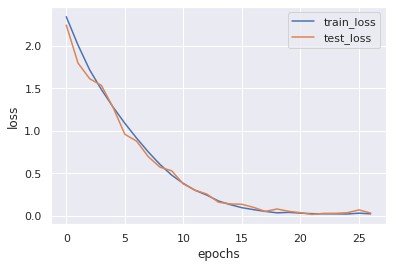

In [44]:
df= pd.read_csv('drive/MyDrive/GEC/ENC_DEC_EMB/history.csv')
plt.plot(range(0, len(df['loss'])), df['loss'], label = 'train_loss')
plt.plot(range(0, len(df['val_loss'])), df['val_loss'], label = 'test_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#### Inference

In [28]:
#Input processor
def input_processor(input_sentence, pad_seq):

  encoder_input = preprocess(input_sentence, add_start_token= True, add_end_token=True)

  #Convert to sequence
  tokenized_text = tokenizer.texts_to_sequences([encoder_input])
  if pad_seq == True:
    tokenized_text = pad_sequences(tokenized_text, maxlen=INPUT_ENCODER_LENGTH, padding="post")

  tokenized_text = tf.convert_to_tensor(tokenized_text, dtype = tf.float32)
  return tokenized_text


def remove_end_token(words):
  words_list = words.split(' ')[:-1]
  words = " ".join(words_list)
  return words

In [29]:
def plot_attention(AW, IN, OUT):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  #Get the attention weights of ALL ENCODER VALUES for every timestep: i.e. if encoder length is 2, and decoder length is 2, you get 4 values

  print(IN)
  print(OUT)
  plt.figure(figsize = (8,6))
  sns.set_theme()
  ax = sns.heatmap(AW,xticklabels =  IN.split(" "), yticklabels= OUT.split(" "))
  ax.set_title('Attention weights')
  ax.set_xlabel('encoder_input')
  ax.set_ylabel('decoder_output')


In [30]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  
  input = input_processor(input_sentence, pad_seq = False)
  #print('INPUT: ', input)

  NUMBER_OF_INPUTS = input.shape[0] #Or number of inputs

  #Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  states = model.layers[0].initialize_states(NUMBER_OF_INPUTS)

  encoder_output,encoder_final_state_h, encoder_final_state_c = model.layers[0](input, states)
  #print('ENCODER OUPUT: ',encoder_output,encoder_final_state_h,encoder_final_state_c, 'FULLSTOP')

  #Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  input_decoder = np.zeros((1,1))
  input_decoder[0][0] = 2  #<start> for eng vocab
  
  attention_wts = []
  decoder_output_list = []

  stop = False

  while stop != True: 
    decoder_output,decoder_state_h,decoder_state_c, attention_weights, context_vector = model.layers[1].one_step_decoder(input_decoder, encoder_output, encoder_final_state_h, encoder_final_state_c)
    
    #Update the states for next prediction
    encoder_final_state_h = decoder_state_h
    #encoder_final_state_h_b = decoder_state_h_b
    encoder_final_state_c = decoder_state_c
    #encoder_final_state_c_b = decoder_state_c_b

    #print('OUTPUT: ',decoder_output)

    index = np.argmax(decoder_output,-1)
    #print('NP.ARGMAX OUTPUT: ', index)

    attention_wts.append(attention_weights)
    decoder_output_list.append(index)

    input_decoder = np.asarray(index, dtype = np.float32)
    input_decoder = np.reshape(input_decoder, (NUMBER_OF_INPUTS,1))

    if input_decoder[0][0] == 4 or len(decoder_output_list) > input.shape[1]: #Index of <end> for out_tokenizer
      stop =True

  #Get the output tokens and store in arr_out
  arr_out = [int(np.asarray(i)) for i in decoder_output_list]

  #Convert to text
  output_words = out_tokenizer.sequences_to_texts([arr_out])

  return output_words, attention_wts
  

In [31]:
def translate(sent, ind, plot_attention_):
  out, attention_weights = predict(sent)

  #Get the output and input sent
  OUT = out[0]
  IN = encoder_input[ind]
  #print(IN)

  if plot_attention_ == True:
    #REshape attention weights
    attention_weights = np.asarray(attention_weights)
    AW = np.reshape(attention_weights,(attention_weights.shape[0], attention_weights.shape[2]))

    #print(AW, AW.shape)

    #Plot attention
    plot_attention(AW, IN, OUT)

  return OUT

#### Inference on model trained with 10k data points



In [35]:
model.load_weights('drive/MyDrive/GEC/ENC_DEC_EMB/weights_22.h5')

ATTENTION PLOTS 

<start> And he took in my favorite subject like soccer . <end>
also took in my favorite subjects like soccer . <end>


'also took in my favorite subjects like soccer . <end>'

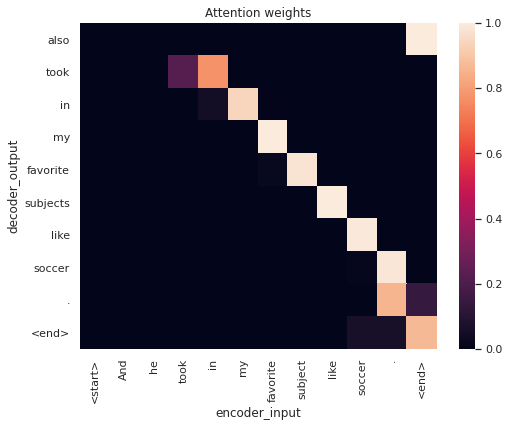

In [36]:
translate(data['error'].loc[0], 0, plot_attention_= True)

<start> His Kanji is ability is much better than me . <end>
his kanji ability is much better than mine . <end>


'his kanji ability is much better than mine . <end>'

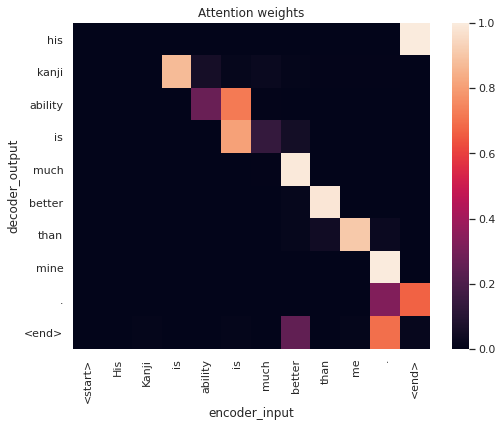

In [37]:
translate(data['error'].loc[2], 2, plot_attention_= True)

<start> You know , you can take them at slot machine . <end>
you know , you can ? <end>


'you know , you can ? <end>'

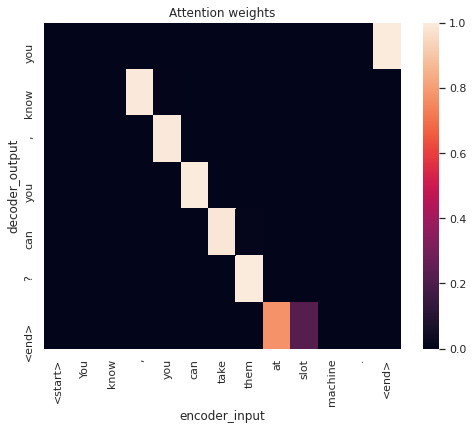

In [38]:
translate(data['error'].loc[7], 7, plot_attention_= True)

<start> If only I had black dense curtains . <end>
even only i had dense black curtains . <end>


'even only i had dense black curtains . <end>'

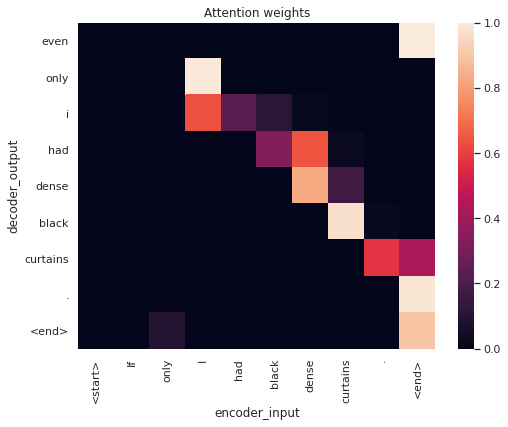

In [39]:
translate(data['error'].loc[11],11, plot_attention_= True)

BLEU SCORES WITH SEEN DATA

In [40]:
#Pick 1000 random indices
indices = [random.randint(0, 10000) for i in range(1000)]
sent_list = [data['error'].loc[i] for i in indices]
bleu_scores_ = []
actual_output = []
output_sent_list = []

#Translate and calculate BLEU scores
for i, sent in enumerate(tqdm(sent_list)):
  out,_ = predict(sent) 
  actual_ = decoder_output[indices[i]]

  output_sent_list.append(out[0])
  actual_output.append(actual_)

  #Remove <end> token
  out_words = remove_end_token(out[0])
  actual_output_ = remove_end_token(actual_)

  #Calculate BLEU scores
  bleu_scores_.append(sentence_bleu(actual_output_.split(' '), out_words.split(' ')))


print('Average BLEU score :',sum(bleu_scores_)/len(bleu_scores_))

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [01:56<00:00,  8.61it/s]

Average BLEU score : 0.6202338005701352


In [41]:
df = pd.DataFrame(columns= ['input_sentence', 'actual_output','translated_output', 'bleu_score'])
df['input_sentence'] = sent_list
df['actual_output'] = actual_output
df['translated_output'] = output_sent_list
df['bleu_score'] = bleu_scores_

In [42]:
df[:50]

,input_sentence,actual_output,translated_output,bleu_score
0,"If I speak English fluently someday , I want to go abroad .","If I can speak English fluently someday , I want to go abroad . <end>","if i can speak english fluently someday , i want to go abroad . <end>",0.680375
1,"Whenever I see this word , I interpret as newspaper article .","Whenever I see this word , I think of a newspaper article . <end>","whenever i see this word , i think of a newspaper article . <end>",0.744782
2,Golden week is a grop of holidays in Japan .,Golden week is a group of holidays in Japan . <end>,golden week is a special of holidays in japan . <end>,0.668740
3,"Zhang , ane - mail and ask for his help .","Zhang , an e - mail and ask for his help . <end>","zhang , an e - mail and ask for his help . <end>",0.759836
4,It is meaning I have to work at casher too .,It means I have to work as a cashier too . <end>,it means i have to work as a cashier too . <end>,0.722657
5,I have to save money if buy a car . . .,I have to save money if I want to buy a car . . . <end>,i have to save money if i can buy a car . . . <end>,0.680375
6,Having a lunch under cherry blossoms is a fantastic experience !,Having lunch under cherry blossoms is a fantastic experience ! <end>,having lunch under cherry blossoms is a fantastic experience ! <end>,0.668740
7,It seems to be able to enjoy it .,It seems to be enjoyable . <end>,it seems to be enjoyable to enjoy it . <end>,0.577350
8,The weather forcast says heavy rain tomorrow .,The weather forcast says there will be heavy rain tomorrow . <end>,the weather forcast says there will be heavy rain tomorrow .,0.000000
9,It takes me to get to Moshi from Dar hours .,It takes me hours to get to Moshi from Dar . <end>,it takes me to go to moshi from dar hours . <end>,0.549100


In [43]:
df[-50:]

,input_sentence,actual_output,translated_output,bleu_score
950,I believe this feeling of angry will make me better .,I believe this feeling of anger will make me better . <end>,i believe this feeling of anger will make me better . <end>,0.652994
951,And then the police caught him in the act of doing it .,And then the police caught him in the act . <end>,and the police caught him in the act . <end>,0.577350
952,I would like to be friend with many people all over the world .,I would like to be friends with many people all over the world . <end>,i would like to be friends with many people all over the world . <end>,0.614788
953,All of them look so happy .,All of them looked so happy . <end>,all of them looked so happy . <end>,0.614788
954,It is really pretty day in Bangkok .,It is a really pretty day in Bangkok . <end>,it is a really pretty day in bangkok . <end>,0.686589
955,He looked embarrassed with shyly smile . . . .,He looked embarrassed and had a shy smiled on his face . . . . <end>,he looked embarrassed and had a shy smiled on his face . .,0.638943
956,I used to use it without sounds recently .,I used it without sounds recently . <end>,used used it without sounds recently . <end>,0.614788
957,I was able to cook them tastily .,I was able to cook them so that they were tasty . <end>,i was able to cook them so that they were tasty,0.000000
958,Thank you for all instructors in the school ! ! ! !,Thank you to all instructors in the school ! ! ! ! <end>,thank you to all instructors in the school ! ! ! ! <end>,0.537285
959,So it is because I would like to a movie without subutitles .,So that is why I would like to watch a movie without subtitles . <end>,so that is why i would like to watch a movie without subtitles . <end>,0.680375


## OBSERVATIONS:

- Model seems to perform well.
- Performance similar to encoder decoder performance
- BLEU score of 0.62

In [2]:
!jupyter-nbconvert --to PDFviaHTML GEC_Baseline_Attention.ipynb

[NbConvertApp] Converting notebook GEC_Baseline_Attention.ipynb to PDFviaHTML
[NbConvertApp] Writing 1055580 bytes to GEC_Baseline_Attention.pdf
